# PID regulator visualization

## Comparison of PID regulator with different parameters

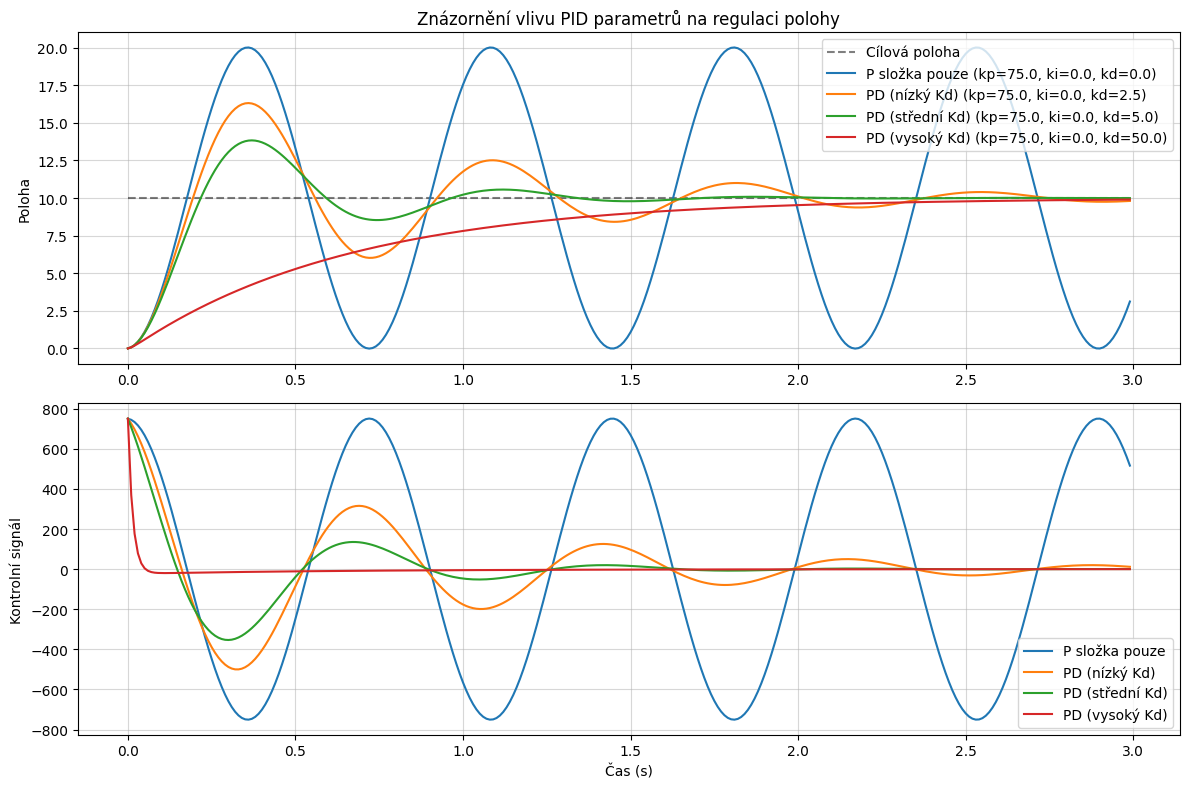

In [99]:
import matplotlib.pyplot as plt
import numpy as np

class PositionPID:
    def __init__(self, kp, ki, kd, dt=0.01, max_integral=10.0):
        # PID gains
        self.kp = kp
        self.ki = ki
        self.kd = kd
        
        # Time step
        self.dt = dt
        
        # Error terms
        self.prev_error = None
        self.integral = 0
        
        # Anti-windup
        self.max_integral = max_integral
        
    def reset(self):
        """Reset internal state"""
        self.prev_error = 0
        self.integral = 0
        
    def update(self, target_pos, current_pos):
        # Calculate error
        error = target_pos - current_pos
        
        if self.prev_error is None:
            self.prev_error = error
        
        # Proportional term
        p_term = self.kp * error
        
        # Integral term with anti-windup
        self.integral += error * self.dt
        self.integral = np.clip(self.integral, -self.max_integral, self.max_integral)
        i_term = self.ki * self.integral
        
        # Derivative term (using time delta)
        d_term = self.kd * (error - self.prev_error) / self.dt
        
        # Calculate output
        output = p_term + i_term + d_term
        
        # Update previous error
        self.prev_error = error
        
        return output

class SystemSimulator:
    def __init__(self, dt=0.01, mass=1.0):
        self.dt = dt
        self.mass = mass
        self.reset()
        
    def reset(self):
        self.position = 0
        self.velocity = 0
        
    def step(self, force, disturbance=0):
        # Simple physics simulation (F = ma)
        acceleration = (force + disturbance) / self.mass
        self.velocity += acceleration * self.dt
        self.position += self.velocity * self.dt
        return self.position

def simulate_single_run(pid_config, target_position, steps=1000, dt=0.01):
    pid = PositionPID(kp=pid_config[0], ki=pid_config[1], kd=pid_config[2], dt=dt)
    system = SystemSimulator(dt=dt)
    
    positions = []
    controls = []
    
    for i in range(steps):
        current_position = system.position
        control = pid.update(target_position, current_position)
        
        # Add disturbance if needed
        # wind_disturbance = np.random.normal(0, 50)  # Random
        # wind_disturbance = 0.2 if i > steps//2 else 0  # Step disturbance
        wind_disturbance = 0  # No disturbance
        # wind_disturbance = 2  # No disturbance
        # wind_disturbance = 1000 if i == 1000 else 0  # Impulse disturbance
        
        system.step(control, wind_disturbance)
        
        positions.append(current_position)
        controls.append(control)
    
    return np.array(positions), np.array(controls)

def plot_comparison(configurations, target_position=10, steps=300, dt=0.01):
    # Use default style
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    time = np.arange(steps) * dt
    
    # Plot target line
    ax1.plot(time, [target_position] * steps, 'k--', label='Cílová poloha', alpha=0.5)
    
    # Different line styles and colors for each configuration
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (config, label) in enumerate(configurations):
        positions, controls = simulate_single_run(config, target_position, steps, dt)
        color = colors[i % len(colors)]
        
        # Plot position
        ax1.plot(time, positions, color=color, 
                label=f'{label} (kp={config[0]}, ki={config[1]}, kd={config[2]})')
        
        # Plot control signal
        ax2.plot(time, controls, color=color, label=label)
    
    # Position plot settings
    ax1.grid(True, alpha=0.5)
    ax1.legend()
    ax1.set_ylabel('Poloha')
    ax1.set_title('Znázornění vlivu PID parametrů na regulaci polohy')
    
    # Control signal plot settings
    ax2.grid(True, alpha=0.5)
    ax2.legend()
    ax2.set_xlabel('Čas (s)')
    ax2.set_ylabel('Kontrolní signál')
    
    plt.tight_layout()
    return fig

configurations = [
	((75.0, 0.0, 0.0), "P složka pouze"),
	((75.0, 0.0, 2.5), "PD (nízký Kd)"),
	((75.0, 0.0, 5.0), "PD (střední Kd)"),
	((75.0, 0.0, 50.0), "PD (vysoký Kd)"),
]

fig = plot_comparison(configurations)
plt.show()

## Break down of the components of the PID regulator
### 1. Integral component

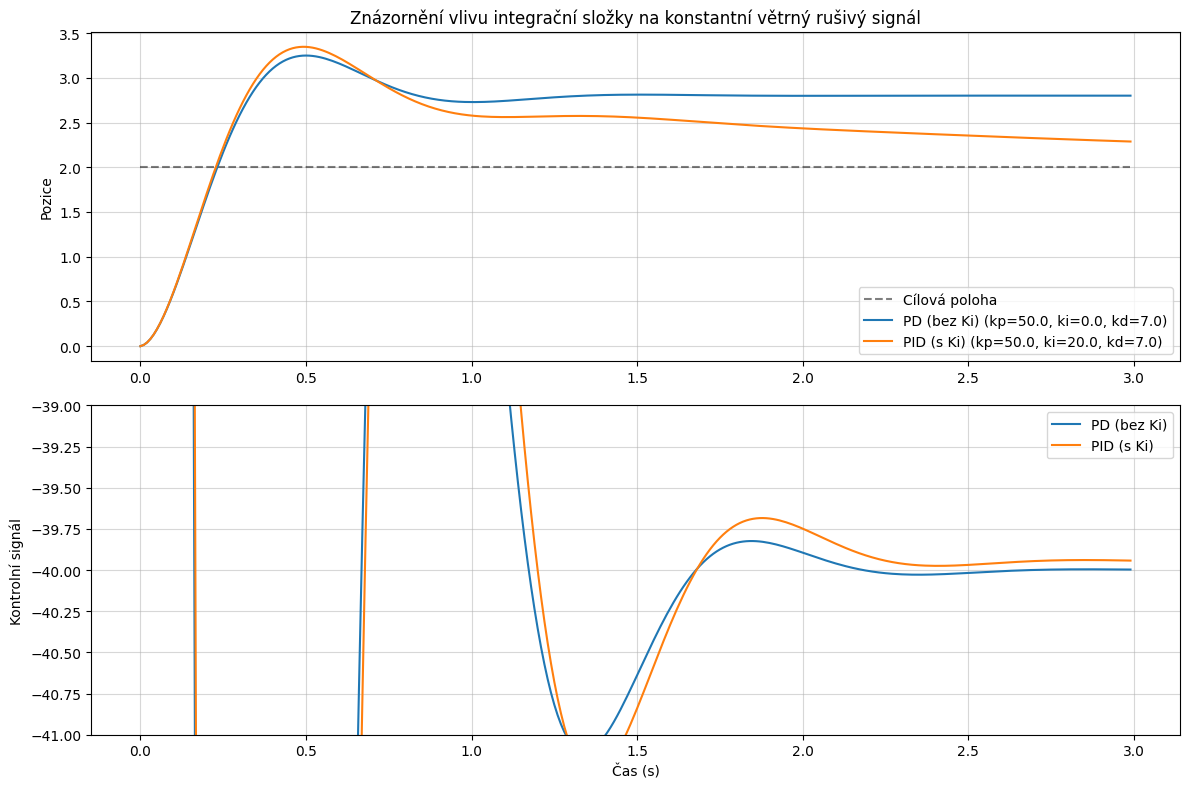

In [100]:
def simulate_single_run(pid_config, target_position, steps=1000, dt=0.01):
    pid = PositionPID(kp=pid_config[0], ki=pid_config[1], kd=pid_config[2], dt=dt)
    system = SystemSimulator(dt=dt)
    
    positions = []
    controls = []
    
    for i in range(steps):
        current_position = system.position
        control = pid.update(target_position, current_position)
        
        # Add disturbance if needed
        # wind_disturbance = np.random.normal(0, 50)  # Random

        # wind_disturbance = 0.2 if i > steps//2 else 0  # Step disturbance
        wind_disturbance = 40 # Constant disturbance
        # wind_disturbance = 0  # No disturbance
        # wind_disturbance = 1000 if i == 1000 else 0  # Impulse disturbance
        
        system.step(control, wind_disturbance)
        
        positions.append(current_position)
        controls.append(control)
    
    return np.array(positions), np.array(controls)

def plot_comparison(configurations, target_position=10, steps=300, dt=0.01):
    # Use default style
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    time = np.arange(steps) * dt
    
    # Plot target line
    ax1.plot(time, [target_position] * steps, 'k--', label='Cílová poloha', alpha=0.5)
    
    # Different line styles and colors for each configuration
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (config, label) in enumerate(configurations):
        positions, controls = simulate_single_run(config, target_position, steps, dt)
        color = colors[i % len(colors)]
        
        # Plot position
        ax1.plot(time, positions, color=color, 
                label=f'{label} (kp={config[0]}, ki={config[1]}, kd={config[2]})')
        
        # Plot control signal
        ax2.plot(time, controls, color=color, label=label)
    
    # Position plot settings
    ax1.grid(True, alpha=0.5)
    ax1.legend()
    ax1.set_ylabel('Pozice')
    ax1.set_title('Znázornění vlivu integrační složky na konstantní větrný rušivý signál')
    
    # Control signal plot settings
    ax2.grid(True, alpha=0.5)
    ax2.legend()
    ax2.set_xlabel('Čas (s)')
    ax2.set_ylabel('Kontrolní signál')
    ax2.set_ylim(-41, -39)
    
    plt.tight_layout()
    return fig

configurations = [
	((50.0, 0.0, 7.0), "PD (bez Ki)"),
	((50.0, 20.0, 7.0), "PID (s Ki)"),
]

fig = plot_comparison(configurations, target_position=2)
plt.show()